 ## <center> 🚩Proyecto Final NLP </center>

## <center> 🚩Análisis de percepción frente a Uber 🚗 en Twitter </center>


<div align="center"><img src="https://parentesis.com/imagesPosts/uber_logo_2017_1.jpg"></div>


**Autor**: *Jeimmy Terreros*, *Keylan Valencia*




## Librerias usadas 📗📘📙

In [48]:
import pandas as pd
import numpy as np
import tweepy
import re 
import json

pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

from flair.models import TextClassifier
from flair.data import Sentence

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

from wordcloud import WordCloud, ImageColorGenerator

from nltk.corpus import stopwords
stopwords = stopwords.words("spanish")

import PIL.Image
from IPython.display import display



## 1. Obtención de Datos  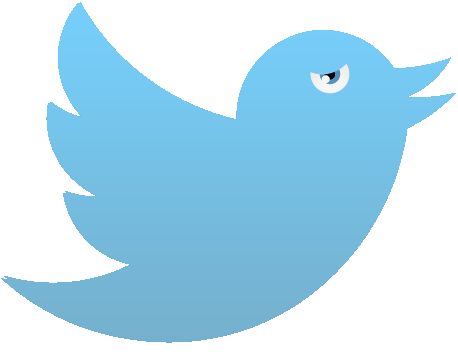 

In [2]:
keys = pd.read_csv("C:/Users/yayat/OneDrive/Documentos/Jeimmy/Universidad/NPL/Clase del 13-05-2021/mis_llaves.csv", header=None)
keys = dict(zip(keys[0],keys[1]))
keys.keys()

dict_keys(['api_key', 'api_secret_key', 'access_token', 'access_token_secret', 'bearer_token'])

In [3]:
auth = tweepy.OAuthHandler(keys['api_key'], keys['api_secret_key'])
auth.set_access_token(keys['access_token'], keys['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

In [4]:
id = None
count = 0
while count <= 3000:
    tweets = api.search(q='uber', lang='es', tweet_mode='extended', max_id=id)
    for tweet in tweets:
        if tweet.full_text.startswith('RT'):
            count += 1
            continue
        f = open('C:/Users/yayat/OneDrive/Documentos/Jeimmy/Universidad/NPL/Proyecto_final/uber.txt','a', encoding='utf-8')
        f.write(tweet.full_text + '\n')
        f.close
        count += 1
    id = tweet.id
    print(count)

9
17
25
40
55
67
82
97
112
127
142
157
172
186
201
216
231
245
260
275
287
302
317
332
347
362
377
392
407
422
437
452
467
482
496
511
526
541
556
569
583
598
613
628
643
658
672
687
702
717
732
747
762
777
792
806
821
836
851
866
881
895
910
925
940
955
970
985
1000
1015
1030
1045
1060
1075
1090
1105
1120
1135
1150
1165
1180
1195
1210
1225
1240
1255
1270
1285
1300
1315
1330
1345
1360
1375
1389
1401
1414
1429
1444
1459
1474
1489
1504
1519
1534
1549
1563
1577
1592
1607
1622
1637
1652
1667
1682
1697
1712
1727
1742
1757
1772
1787
1802
1814
1829
1844
1859
1874
1889
1904
1919
1932
1947
1962
1977
1992
2007
2022
2037
2052
2067
2082
2097
2112
2126
2141
2156
2171
2186
2200
2215
2230
2245
2260
2275
2290
2305
2320
2334
2348
2362
2377
2392
2407
2422
2437
2451
2465
2476
2491
2505
2520
2535
2550
2565
2580
2595
2609
2621
2636
2651
2666
2681
2696
2711
2726
2741
2754
2769
2784
2799
2814
2828
2843
2858
2873
2888
2902
2915
2930
2945
2960
2975
2990
3005


## Tweets Obtenidos 🛬

In [3]:
data = pd.read_fwf("C:/Users/KeylanRolandoValenci/Documents/Varios Keylan/Clases Especialización/Clases Especialización/Semestre II/NLP/uber1.txt", header=None, names=['Tweets','vacios'])
data.head(5)

Tweets vacios
0  @ArqAngelaLara Después que cierras la APP y el...    NaN
1  Ayer hablaba de eso con un chofer de Uber. Ins...    NaN
2  @JAYMARCUS13 Una tipa hizo una publicación sob...    NaN
3                                    Q uber idiota 🙄    NaN
4  @bolivarvalera Que el uber será toda la vida u...    NaN

## 2. Limpieza de Datos 🧹

In [5]:
def text_clean(row):
    text = row['Tweets']
    
    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")
    
    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag, "")
        
    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention, "")
        
    return text, links, hashtags, mentions

data[['texto_limpio', 'links', 'hashtags', 'mentions']] = data.apply(text_clean, axis=1, result_type='expand')
data

Tweets vacios  \
0     @ArqAngelaLara Después que cierras la APP y el...    NaN   
1     Ayer hablaba de eso con un chofer de Uber. Ins...    NaN   
2     @JAYMARCUS13 Una tipa hizo una publicación sob...    NaN   
3                                       Q uber idiota 🙄    NaN   
4     @bolivarvalera Que el uber será toda la vida u...    NaN   
...                                                 ...    ...   
2022                                             Bogotá    NaN   
2023                 3508869199 https://t.co/xeesj5ic0j    NaN   
2024  @jiminhoneybts Yo lo pedí por uber llego super...    NaN   
2025  @A24COM por las dudas aviso mi ausencia, tengo...    NaN   
2026  tengo tantas ganas del helado de lucciano’s qu...    NaN   

                                           texto_limpio  \
0      Después que cierras la APP y el viaje, no hay...   
1     Ayer hablaba de eso con un chofer de Uber. Ins...   
2      Una tipa hizo una publicación sobre un Uber q...   
3                                       Q uber idiota 🙄   
4                   Que el uber será toda la vida uber🙊   
...                                                 ...   
2022                                             Bogotá   
2023                                        3508869199    
2024   Yo lo pedí por uber llego super rápido y bien...   
2025   por las dudas aviso mi ausencia, tengo un tra...   
2026  tengo tantas ganas del helado de lucciano’s qu...   

                          links hashtags          mentions  
0                            []       []  [@ArqAngelaLara]  
1     [https://t.co/dbNecBLuFs]       []                []  
2                            []       []    [@JAYMARCUS13]  
3                            []       []                []  
4                            []       []  [@bolivarvalera]  
...                         ...      ...               ...  
2022                         []       []                []  
2023  [https://t.co/xeesj5ic0j]       []                []  
2024  [https://t.co/Pqu4K3Hti5]       []  [@jiminhoneybts]  
2025                         []       []         [@A24COM]  
2026                         []       []                []  

[2027 rows x 6 columns]

In [6]:
import regex
import emoji

def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)

    return emoji_list
  
  

data['emojis'] = data['texto_limpio'].apply(lambda text: get_emojis(text))
data.head()

Tweets vacios  \
0  @ArqAngelaLara Después que cierras la APP y el...    NaN   
1  Ayer hablaba de eso con un chofer de Uber. Ins...    NaN   
2  @JAYMARCUS13 Una tipa hizo una publicación sob...    NaN   
3                                    Q uber idiota 🙄    NaN   
4  @bolivarvalera Que el uber será toda la vida u...    NaN   

                                        texto_limpio  \
0   Después que cierras la APP y el viaje, no hay...   
1  Ayer hablaba de eso con un chofer de Uber. Ins...   
2   Una tipa hizo una publicación sobre un Uber q...   
3                                    Q uber idiota 🙄   
4                Que el uber será toda la vida uber🙊   

                       links hashtags          mentions emojis  
0                         []       []  [@ArqAngelaLara]     []  
1  [https://t.co/dbNecBLuFs]       []                []     []  
2                         []       []    [@JAYMARCUS13]     []  
3                         []       []                []    [🙄]  
4                         []       []  [@bolivarvalera]    [🙊]

In [9]:
pd.set_option('display.max_colwidth', None)
data = data[['texto_limpio']]
data.head(5)

texto_limpio
0   Después que cierras la APP y el viaje, no hay forma de contactarse solo denunciar vía Über, y justo hace unos días alguien estaba tratando de comunicarse cn las oficinas de Uber y nadie le contestaba.
1                                              Ayer hablaba de eso con un chofer de Uber. Insistía con bajar la llave, a lo que le pregunté sobre que planes tenía para sobrevivir: no supo responderme.... 
2                       Una tipa hizo una publicación sobre un Uber que le “robo” pertenencias y resulta ser que tales pertenecías eran unas cantinas de comida, se niega a pedir disculpas y es muy pedante
3                                                                                                                                                                                            Q uber idiota 🙄
4                                                                                                                                                                        Que el uber será toda la vida uber🙊

In [12]:
from nltk.corpus import stopwords
stopwords_sp = stopwords.words('spanish')

In [13]:


def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect_kmeans = TfidfVectorizer(preprocessor=pre_procesado)
tfidf_kmeans = tfidf_vect_kmeans.fit_transform(data.texto_limpio.values)
tfidf_matrix = pd.DataFrame(tfidf_kmeans.toarray(), columns=tfidf_vect_kmeans.get_feature_names())

### 3. Modelo de Cluster ❄

In [14]:
ks = []
k_inertias = []

for k in range(1,21):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_
    
    ks.append(k)
    k_inertias.append(k_inertia)

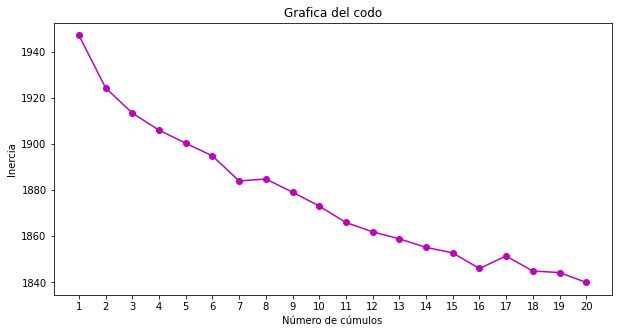

In [15]:
plt.figure(figsize=(10,5))
plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title("Grafica del codo")
plt.xticks(ks)
plt.plot(ks, k_inertias, 'mo-');

In [16]:
k =7

model =KMeans(n_clusters=k)
model.fit(tfidf_matrix)


KMeans(n_clusters=7)

In [17]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'  
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [18]:
nbrs = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(tfidf_matrix.values)

data['cluster'] = model.labels_
clust_cnt = data['cluster'].value_counts()
clust_cnt_pct = data['cluster'].value_counts(normalize=True)

print(f"{color.BOLD}CLUSTERS:\n{color.END}")
centroids = model.cluster_centers_
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect_kmeans.get_feature_names()

for i in range(k):
    print(f"{color.BLUE}Cluster {i}:{color.END}")
    print(f"{color.CYAN}COUNT {color.END} {clust_cnt[i]} comments ({clust_cnt_pct[i]:.2%} of the data)")
    print(f"{color.CYAN}TERMS {color.END}", end=" ")
    for ind in order_centroids[i, :20]:
        print(f'{color.BOLD}{terms[ind]}{color.END}', end=" "),
    print(f"\n{color.CYAN}REPRESENTATIVE COMMENTS{color.END}")
    for comment in data.iloc[nbrs.kneighbors([centroids[i]])[1][0]]['texto_limpio'].values:
        print(f"* {comment}")
    print("\n")

CLUSTERS:

Cluster 0:
COUNT  787 comments (38.83% of the data)
TERMS  uber servicio tan dice voy así mas casa gracias minutos taxi gente solo vez ser app bien carro trabajo hacer 
REPRESENTATIVE COMMENTS
* [2/2]
* 


Cluster 1:
COUNT  34 comments (1.68% of the data)
TERMS  dm correo número teléfono hola fecha envíanos viaje código hora junto compártenos telefónico electrónico queremos cuenta dígitos últimos síguenos situación 
REPRESENTATIVE COMMENTS
* [2/2]
* 


Cluster 2:
COUNT  57 comments (2.81% of the data)
TERMS  toda vida vas ser uber va hacer usted diablo mujer tipa coño loca freca ohhh seras padre amado prepotencia dizque 
REPRESENTATIVE COMMENTS
* “Tú vas a ser uber toda tu vida”. 😔🤮
* La ella: TU VAS A SER UBER TODA LA VIDA!!


Cluster 3:
COUNT  715 comments (35.27% of the data)
TERMS  uber cantina sala twitter siempre cuenta tipa ser pobre señora show pollo anda joven hizo mañana entrevista caso muchacho va 
REPRESENTATIVE COMMENTS
* [2/2]
* 


Cluster 4:
COUNT  114 comment

## Gráfica PCA 📈

In [19]:
pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['cluster'] = data.cluster.values
result['texto'] = data.texto_limpio.apply(lambda val: val[:140])

trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=result['cluster'].values)) 

layout = go.Layout(title="PCA")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

## Nube de Palabras  ☁


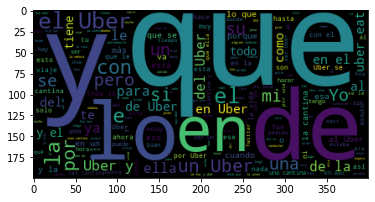

In [29]:
palabras = data.texto_limpio.str.cat(sep=" ")
wordcloud1 = WordCloud().generate(palabras)

plt.imshow(wordcloud1)
plt.show()

In [42]:
palabras = data.texto_limpio.str.cat(sep=" ")
palabras

' Después que cierras la APP y el viaje, no hay forma de contactarse solo denunciar vía Über, y justo hace unos días alguien estaba tratando de comunicarse cn las oficinas de Uber y nadie le contestaba. Ayer hablaba de eso con un chofer de Uber. Insistía con bajar la llave, a lo que le pregunté sobre que planes tenía para sobrevivir: no supo responderme....   Una tipa hizo una publicación sobre un Uber que le “robo” pertenencias y resulta ser que tales pertenecías eran unas cantinas de comida, se niega a pedir disculpas y es muy pedante Q uber idiota 🙄  Que el uber será toda la vida uber🙊 Ahorita sale en alofoke la tipa de la cantina con el taxista de Uber con su derecho a réplica FAM EL SEÑOR DEL UBER ME CONTESTO VOY A RECUPERAR MIS LENTES  Quiso humillar al Uber!!!??? Asi nooo!   Para eso está uber Pero y este tema de la señora del uber y su cantina. i love twitter😂😂😂😭  ha estado muy callado 👀      Sí claro, especialmente negandose a legalizar uber para mantener el monopolio de taxis

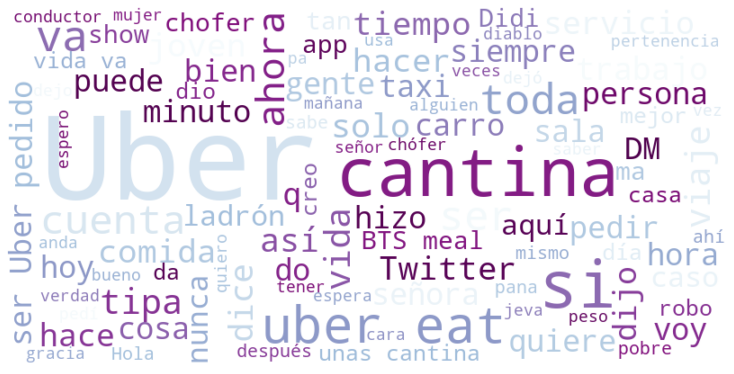

In [49]:
palabras = data.texto_limpio.str.cat(sep=" ")
wordcloud = WordCloud(width=800, height=400,
                      max_font_size=130, max_words=100,
                      background_color="white", colormap="BuPu",
                      stopwords=stopwords).generate(palabras) # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

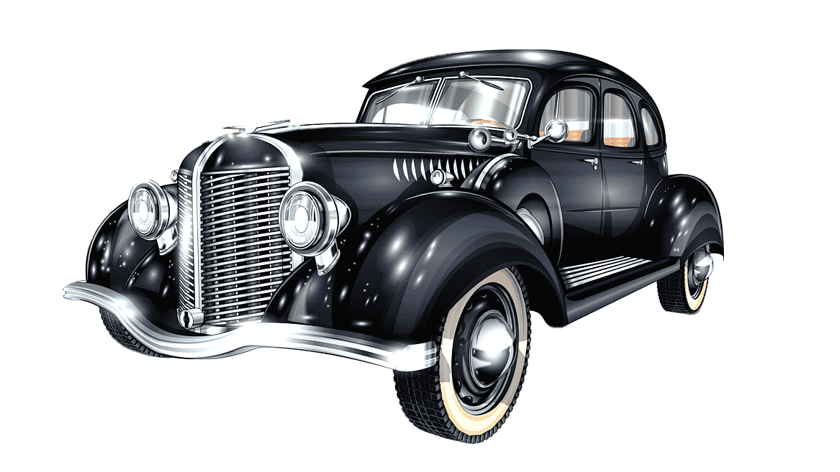

In [50]:
img = PIL.Image.open("C:/Users/KeylanRolandoValenci/Downloads/cc2.png")
display(img)

In [51]:
mask = np.array(img)

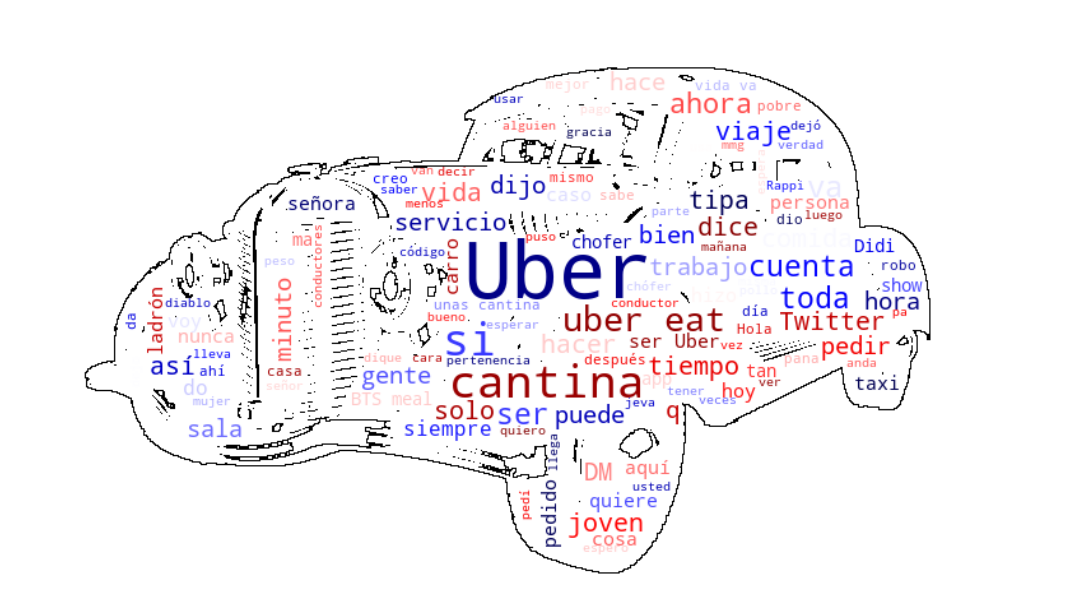

In [56]:
palabras = data.texto_limpio.str.cat(sep=" ")
wordcloud = WordCloud(width=1000, height=600,
                      max_font_size=120, max_words=120,
                      background_color="white", colormap="seismic",
                      stopwords=stopwords, collocations=True,
                      mask=mask, contour_width=1, contour_color='black').generate(palabras) 

wordcloud.to_file("nlp_carro.png")

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0.5)
plt.show()

## Tendencias en Redes 😏

https://www.diariolibre.com/actualidad/cantinagate-el-mas-reciente-fenomeno-en-redes-sociales-DG26642607


https://hoy.com.do/video-que-es-el-cantinagate/

